In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

**1. The number of busy lines in a trunk group (Erlang system) is given by a truncated Poisson distribution. Generate values from this distribution by applying the Metropolis-Hastings algorithm, verify with a χ2-test. You can use the parameter values from exercise 4.**

In [2]:
#Transition model
def g(i):
    return (A**i)/np.math.factorial(i)

def erlang(i, K):
    return ((A**i)/np.math.factorial(i)) / K

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform()
        return (accept < x_new/x)

#Main algorithm
def metropolis_hastings(param_init,iterations,g,acceptance_rule):
    x = param_init
    accepted = []
    rejected = []   
    while len(accepted)<iterations:
        rnd=np.random.uniform()
        if rnd<0.5:
            updated_x = x-1
        else:
            updated_x = x+1
        if updated_x < 0:
            updated_x = 10
        if updated_x > 10:
            updated_x = 0
        x_new = g(updated_x)
        current_x = g(x) 
        if acceptance_rule(current_x,x_new):            
            x = updated_x
            accepted.append(x)
        else:
            rejected.append(x)            
                
    return np.array(accepted), np.array(rejected)

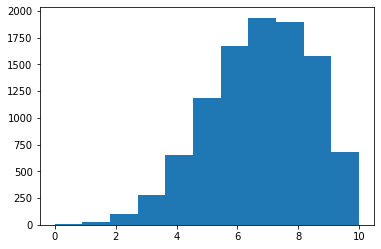

In [3]:
A = 8
initial_state = 0
accepted, rejected = metropolis_hastings(initial_state,10000,g,acceptance)
plt.hist(accepted,bins=11)
plt.savefig('ex6_erlang.png')

In [4]:
def chi_squared_test(x, x_exp, k, x_lower=0, x_upper=1, print_results=True):
    x = [x[i] for i in range(0,len(x),5)]
    x_exp = [x_exp[i] for i in range(0,len(x_exp),5)]
    x_obs, bins = np.histogram(x, bins=k, range=(0, k-1))
    x_exp, bins = np.histogram(x_exp, bins=k, range=(0, k-1))
    T = sum([(x_obs[i] - x_exp[i])**2/x_exp[i] for i in range(k)])
    critical_value = st.chi2.ppf(0.95, k - 1)
    if print_results:
        print('\n--- Chi-Squared test results ---')
        print('T =', T)
        print('critical value =', critical_value)
        print('1 - cdf(T, k-1) =', 1 - st.chi2.cdf(T, k - 1))
        if st.chi2.cdf(T, k - 1) < 0.95:
            print('No significant difference detected')
        else:
            print('Significant difference detected!')

(array([   6.,   33.,  128.,  337.,  685., 1127., 1510., 1765., 1710.,
        1463., 1236.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <BarContainer object of 11 artists>)

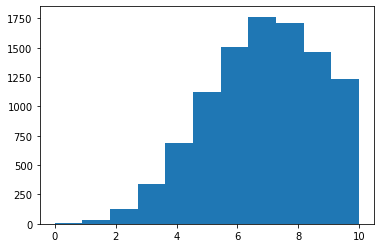

In [5]:
x = np.random.uniform(size=10000)
K = sum([g(i) for i in range(11)])
Pi = [erlang(x,K) for x in range(11)]
# direct (crude) method
y = []
for sp in x:
    val = 0
    cumpi = 0
    for i in range(len(Pi)):
        cumpi += Pi[i]
        if sp <= cumpi:
            y.append(val)
            break
        else:
            val += 1

plt.hist(y, bins=11)

In [6]:
chi_squared_test(accepted,y,11)


--- Chi-Squared test results ---
T = 71.1065780679218
critical value = 18.307038053275146
1 - cdf(T, k-1) = 2.7096658250513883e-11
Significant difference detected!


In [7]:
x_obs, bins = np.histogram(accepted, bins=11, range=(0, 11-1))
x_exp, bins = np.histogram(y, bins=11, range=(0, 11-1))
print(f'x_observed={x_obs}')
print(f'x_expected={x_exp}')

x_observed=[   4   28   99  275  649 1182 1673 1936 1894 1577  683]
x_expected=[   6   33  128  337  685 1127 1510 1765 1710 1463 1236]


In [15]:
#Updated algorithm
def metropolis_hastings(param_init,iterations,g,acceptance_rule):
    x = param_init
    accepted = []
    rejected = []   
    while len(accepted)<iterations:
        rnd=np.random.uniform()
        if rnd<0.5:
            updated_x = x-1
        else:
            updated_x = x+1
        if updated_x < 0 or updated_x > 10:
            accepted.append(x)
            continue
        x_new = g(updated_x)
        current_x = g(x) 
        if acceptance_rule(current_x,x_new):            
            x = updated_x
            accepted.append(x)
        else:
            rejected.append(x)            
                
    return np.array(accepted), np.array(rejected)

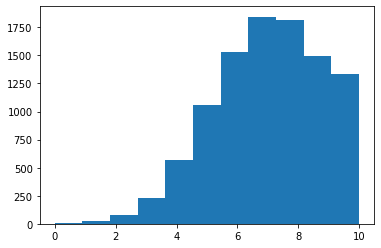

In [16]:
A = 8
initial_state = 0
accepted, rejected = metropolis_hastings(initial_state,10000,g,acceptance)
plt.hist(accepted,bins=11)
plt.savefig('ex6_erlang_updated.png')

In [17]:
chi_squared_test(accepted,y,11)

x_obs, bins = np.histogram(accepted, bins=11, range=(0, 11-1))
x_exp, bins = np.histogram(y, bins=11, range=(0, 11-1))
print(f'x_observed={x_obs}')
print(f'x_expected={x_exp}')


--- Chi-Squared test results ---
T = 26.19010645772049
critical value = 18.307038053275146
1 - cdf(T, k-1) = 0.0034927433701420485
Significant difference detected!
x_observed=[   7   23   81  231  567 1061 1535 1845 1817 1495 1338]
x_expected=[   6   33  128  337  685 1127 1510 1765 1710 1463 1236]


**2.  For two different call types the joint number of occupied lines
is given by ... You can use A1, A2 = 4 and m = 10.**

**(a) Use Metropolis-Hastings, directly to generate variates from
this distribution.**

In [18]:
def g_2d(i, j):
    return ((A1**i)/np.math.factorial(i)) * ((A2**j)/np.math.factorial(j))

def erlang_2d(i, j, K):
    if i+j > 10:
        return 0.0
    return (1/K) * ((A1**i)/np.math.factorial(i)) * ((A2**j)/np.math.factorial(j))

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform()
        return (accept < x_new/x)

#Main algorithm
def metropolis_hastings_1d_1d(param_init,iterations,g,acceptance_rule):
    x = param_init
    accepted = []
    rejected = []
    idx = 0
    while len(accepted)<iterations:
        if (len(accepted) % 1000) == 0:
            print(f'{len(accepted)} iterations...')
        if idx == 0:
            updated = (11,x[1])
        else:
            updated = (x[0],11)
        while sum(updated)>10:
            rnd=np.random.uniform()
            if rnd<0.5:
                updated_idx = x[idx]-1
            else:
                updated_idx = x[idx]+1
            if updated_idx < 0:
                updated_idx = 10
            if updated_idx > 10:
                updated_idx = 0
            if idx == 0:
                updated = (updated_idx,x[1])
            else:
                updated = (x[0],updated_idx)
        if idx == 0:
            idx += 1
        else:
            idx = 0
        x_new = g(updated[0],updated[1])
        current_x = g(x[0],x[1]) 
        if acceptance_rule(current_x,x_new):            
            x = updated
            accepted.append(x)
        else:
            rejected.append(x)            
                
    return np.array(accepted), np.array(rejected)

0 iterations...
1000 iterations...
2000 iterations...
3000 iterations...
4000 iterations...
5000 iterations...
6000 iterations...
7000 iterations...
8000 iterations...
9000 iterations...
9000 iterations...


(array([[  2.,  13.,  25.,  35.,  30.,  18.,  12.,   5.,   3.,   0.],
        [  8.,  68., 158., 215., 190., 125.,  72.,  33.,  16.,   3.],
        [ 13., 129., 317., 455., 414., 289., 172.,  83.,  18.,   0.],
        [ 14., 169., 381., 555., 556., 417., 253.,  69.,   0.,   0.],
        [ 22., 142., 358., 547., 546., 417., 164.,   0.,   0.,   0.],
        [ 19., 120., 277., 440., 440., 183.,   0.,   0.,   0.,   0.],
        [ 14.,  86., 165., 262., 166.,   0.,   0.,   0.,   0.,   0.],
        [  9.,  52.,  97.,  71.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  6.,  27.,  28.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  2.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <matplotlib.collections.QuadMesh at 0x19218cf4640>)

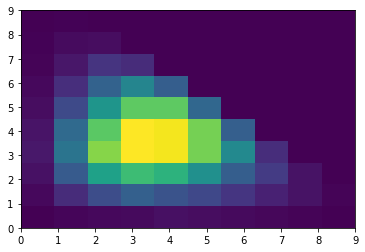

In [20]:
A1 = 4
A2 = 4
m = 10

accepted, rejected = metropolis_hastings_1d_1d((0,0),10000,g_2d,acceptance)
accepted_i = [i[0] for i in accepted]
accepted_j = [j[1] for j in accepted]
plt.hist2d(accepted_i, accepted_j, bins=10)

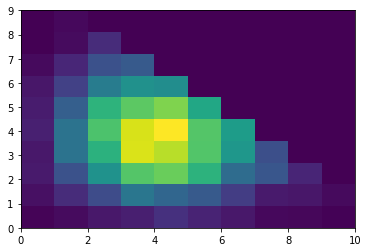

In [27]:
x = np.random.uniform(size=10000)
K = sum([g(i) for i in range(11)])

Pi = [[erlang_2d(i,j,K) for j in range(11)] for i in range(11)]
# direct (crude) method
y = []
counter = 0
for sp in x:
    cumpi = 0
    found = False
    for i, row in enumerate(Pi):
        for j, value in enumerate(row):
            cumpi += value
            if sp <= cumpi:
                y.append((i,j))
                found = True
                break
        if found:
            break

y_i = [i[0] for i in y]
y_j = [j[1] for j in y]
plt.hist2d(y_i, y_j, bins=10)
plt.savefig('ex6_orig_erlang_2d')

In [22]:
def chi_squared_test_2d(x, x_exp, k, x_lower=0, x_upper=1, print_results=True):
    x_i = [x[i][0] for i in range(0,len(x),5)]
    x_j = [x[j][1] for j in range(0,len(x),5)]
    x_exp_i = [x_exp[i][0] for i in range(0,len(x_exp),5)]
    x_exp_j = [x_exp[j][1] for j in range(0,len(x_exp),5)]
    x_obs, bins_i, bins_j = np.histogram2d(x_i, x_j, bins=(k,k))
    x_exp, bins_i, bins_j = np.histogram2d(x_exp_i, x_exp_j, bins=(k,k))
    T = sum([sum([(x_obs[i][j] - x_exp[i][j])**2/x_exp[i][j] if x_exp[i][j]!=0 else 0.0 for j in range(k)]) for i in range(k)])
    critical_value = st.chi2.ppf(0.95, k - 1)
    if print_results:
        print('\n--- Chi-Squared test results ---')
        print('T =', T)
        print('critical value =', critical_value)
        print('1 - cdf(T, k-1) =', 1 - st.chi2.cdf(T, k - 1))
        if st.chi2.cdf(T, k - 1) < 0.95:
            print('No significant difference detected')
        else:
            print('Significant difference detected!')

In [34]:
chi_squared_test_2d(accepted,y,11)


--- Chi-Squared test results ---
T = 713.058935083138
critical value = 18.307038053275146
1 - cdf(T, k-1) = 0.0
Significant difference detected!


In [32]:
#Main algorithm
def metropolis_hastings_alternative(param_init,iterations,g,acceptance_rule):
    x = param_init
    accepted = []
    rejected = []
    while len(accepted)<iterations:
        if (len(accepted) % 1000) == 0:
            print(f'{len(accepted)} iterations...')
        updated = (10,10)
        while sum(updated)>10:
            updated = x
            rnd=np.random.uniform()
            if rnd<0.25:
                updated_idx = x[0]-1
                if updated_idx<0:
                    updated_idx = 10
                updated = (updated_idx,x[1])
            elif rnd<0.5:
                updated_idx = x[0]+1
                if updated_idx>10:
                    updated_idx = 0
                updated = (updated_idx,x[1])
            elif rnd<0.75:
                updated_idx = x[1]-1
                if updated_idx<0:
                    updated_idx = 10
                updated = (x[0],updated_idx)
            else:
                updated_idx = x[1]+1
                if updated_idx>10:
                    updated_idx = 0
                updated = (x[0],updated_idx)
        p_now = set()
        for i in range(x[0]-1,x[0]+1):
            for j in range(x[1]-1,x[1]+1):
                new = (i,j)
                if new[0]>10:
                    new = (0,new[1])
                if new[1]>10:
                    new = (new[0],0)
                if new[0]<0:
                    new = (10,new[1])
                if new[1]<0:
                    new = (new[0],10)
                if sum(new)<=10:
                    p_now.add(new)
        p_now = 1/len(p_now)
        p_new = set()
        for i in range(x[0]-1,x[0]+1):
            for j in range(x[1]-1,x[1]+1):
                new = (i,j)
                if new[0]>10:
                    new = (0,new[1])
                if new[1]>10:
                    new = (new[0],0)
                if new[0]<0:
                    new = (10,new[1])
                if new[1]<0:
                    new = (new[0],10)
                if sum(new)<=10:
                    p_new.add(new)
        p_new = 1/len(p_new)
        #print(f'x={x} p={p_now} x_new={updated} p_new={p_new}')
        x_new = g(updated[0],updated[1])*p_new
        current_x = g(x[0],x[1])*p_now
        if acceptance_rule(current_x,x_new):            
            x = updated
            accepted.append(x)
        else:
            rejected.append(x)            
                
    return np.array(accepted), np.array(rejected)

0 iterations...
0 iterations...
1000 iterations...
2000 iterations...
3000 iterations...
4000 iterations...
5000 iterations...
6000 iterations...
7000 iterations...
8000 iterations...
9000 iterations...


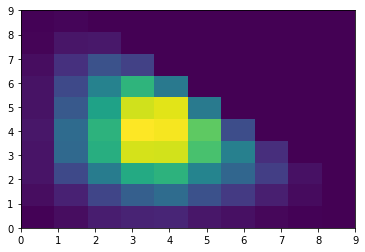

In [33]:
A1 = 4
A2 = 4
m = 10
K = sum([g(i) for i in range(11)])

accepted, rejected = metropolis_hastings_alternative((0,0),10000,g_2d,acceptance)
accepted_i = [i[0] for i in accepted]
accepted_j = [j[1] for j in accepted]
plt.hist2d(accepted_i, accepted_j, bins=10)
plt.savefig('ex6_erlang_2d.png')

**(b) Use Metropolis-Hastings, coordinate wise to generate
variates from this distribution.**

In [17]:
#Main algorithm
def metropolis_hastings_2d(param_init,iterations,g,acceptance_rule):
    x = param_init
    accepted = []
    rejected = []
    while len(accepted)<iterations:
        updated = (10,10)
        while sum(updated)>10:
            rnd=(np.random.uniform(),np.random.uniform())
            if rnd[0]<0.5:
                updated = (x[0]-1,0)
            else:
                updated = (x[0]+1,0)
            if rnd[1]<0.5:
                updated = (updated[0],x[1]-1)
            else:
                updated = (updated[0],x[1]+1)
            if updated[0] < 0:
                updated = (10,updated[1])
            if updated[1] < 0:
                updated = (updated[0],10)
            if updated[0] > 10:
                updated = (0,updated[1])
            if updated[1] > 10:
                updated = (updated[0],0)
        x_new = g(updated[0],updated[1])
        current_x = g(x[0],x[1]) 
        if acceptance_rule(current_x,x_new):            
            x = updated
            accepted.append(x)
        else:
            rejected.append(x)            
                
    return np.array(accepted), np.array(rejected)

(array([[2.000e+00, 0.000e+00, 4.200e+01, 0.000e+00, 6.500e+01, 0.000e+00,
         2.800e+01, 0.000e+00, 8.000e+00, 2.000e+00],
        [0.000e+00, 9.600e+01, 0.000e+00, 2.920e+02, 0.000e+00, 2.200e+02,
         0.000e+00, 7.800e+01, 0.000e+00, 1.000e+01],
        [4.500e+01, 0.000e+00, 4.880e+02, 0.000e+00, 6.850e+02, 0.000e+00,
         3.130e+02, 0.000e+00, 7.900e+01, 0.000e+00],
        [0.000e+00, 3.000e+02, 0.000e+00, 1.023e+03, 0.000e+00, 7.380e+02,
         0.000e+00, 2.380e+02, 0.000e+00, 0.000e+00],
        [6.800e+01, 0.000e+00, 7.690e+02, 0.000e+00, 1.022e+03, 0.000e+00,
         4.050e+02, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 2.750e+02, 0.000e+00, 8.520e+02, 0.000e+00, 4.890e+02,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [3.200e+01, 0.000e+00, 4.130e+02, 0.000e+00, 4.350e+02, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 1.020e+02, 0.000e+00, 2.760e+02, 0.000e+00, 0.000e+00,
         0.000e+00, 0.

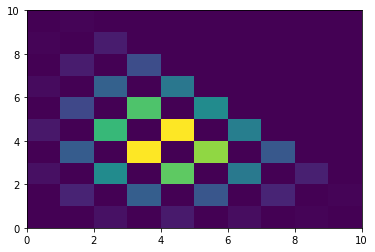

In [18]:
A1 = 4
A2 = 4
m = 10
K = sum([g(i) for i in range(11)])

accepted, rejected = metropolis_hastings_2d((0,0),10000,g_2d,acceptance)
accepted_i = [i[0] for i in accepted]
accepted_j = [j[1] for j in accepted]
plt.hist2d(accepted_i, accepted_j, bins=10)

In [19]:
chi_squared_test_2d(accepted,y,10)


--- Chi-Squared test results ---
T = 1833.832864546328
critical value = 16.918977604620448
1 - cdf(T, k-1) = 0.0
Significant difference detected!


**(c) Use Gibbs sampling to sample from the distribution. This is
(also) coordinate-wise but here we use the exact conditional
distributions. You will need to find the conditional
distributions analytically.**

In [ ]:
#Main algorithm
def gibbs_sampling(param_init,iterations,g,acceptance_rule):
    x = param_init
    accepted = []
    rejected = []
    while len(accepted)<iterations:
        updated = (10,10)
        while sum(updated)>10:
            rnd=(np.random.uniform(),np.random.uniform())
            if rnd[0]<0.5:
                updated = (x[0]-1,0)
            else:
                updated = (x[0]+1,0)
            if rnd[1]<0.5:
                updated = (updated[0],x[1]-1)
            else:
                updated = (updated[0],x[1]+1)
            if updated[0] < 0:
                updated = (10,updated[1])
            if updated[1] < 0:
                updated = (updated[0],10)
            if updated[0] > 10:
                updated = (0,updated[1])
            if updated[1] > 10:
                updated = (updated[0],0)
        x_new = g(updated[0],updated[1])
        current_x = g(x[0],x[1]) 
        if acceptance_rule(current_x,x_new):            
            x = updated
            accepted.append(x)
        else:
            rejected.append(x)            
                
    return np.array(accepted), np.array(rejected)

In [ ]:
A1 = 4
A2 = 4
m = 10
K = sum([g(i) for i in range(11)])

accepted, rejected = gibbs_sampling((0,0),10000,h,acceptance)
accepted_i = [i[0] for i in accepted]
accepted_j = [j[1] for j in accepted]
plt.hist2d(accepted_i, accepted_j, bins=10)

In [ ]:
chi_squared_test_2d(accepted,y,10)

**3. We consider a Bayesian statistical problem. The observations
are Xi ∼ N(Θ, Ψ), where the prior distribution of the pair
(Ξ, Γ) = (log (Θ), log (Ψ)) is standard normal with correlation (...) The joint density f(x, y) of (Θ, Ψ) is
(...) which can be derived using a standard change of variable
technique. The task of this exercise is now to sample from the
posterior distribution of (Θ, Ψ) using Markov Chain Monte
Carlo.**

**(a) Generate a pair (θ, ψ) from the prior distribution, i.e. the
distribution for the pair (Θ, Ψ), by first generating a sample
(ξ, γ) of (Ξ, Γ).**

**(b) Generate Xi = 1, . . . , n with the values of (θ, ψ) you
obtained in item 3a. Use n = 10.**

**(c) Derive the posterior distribution of (Θ, Ψ) given the sample.
Hint 1 Apply Bayes theorem in the density version.
Hint 2 The sample mean and sample variance are
independent. The sample mean follows a normal
distribution, while a scaled version of the sample variance
follows a χ2 distribution.**

**(d) Generate MCMC samples from the posterior distribution of
(Θ, Ψ) using the Metropolis Hastings method.**

**(e) Repeat item 3d with n = 100 and n = 1000, still using the
values of (θ, ψ) from item 3a. Discuss the results.**

In [15]:
#TODO: COORDINATE-WISE??
#TODO: HOW TO MANAGE WITH 2D ARRAYS FOR CHI SQUARE??
#TODO: HOW TO GET THE PRIOR?? GIBBS SAMPLING??

In [16]:
counter = 0
for i in range(11):
    for j in range(11-i):
        counter += 1
counter

66